In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Load the Togo dataset

In [2]:
file_path = '../data/togo-dapaong_qc.csv'

### Handle the error appropriately, maybe exit or load a different file

In [3]:
try:
    df = pd.read_csv(file_path, sep=",", encoding="utf-8")
    print(f"Successfully loaded: {file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    

Successfully loaded: ../data/togo-dapaong_qc.csv


## *** Summary Statistics & Missing-Value Report ***

### df.describe()

In [4]:
print("\n--- Summary Statistics ---")
print(df.describe())


--- Summary Statistics ---
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000000   
25%  

### df.isna().sum()

In [5]:
print("\n--- Missing Value Report ---")
print(df.isna().sum())


--- Missing Value Report ---
Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64


### any column with >5% nulls

In [6]:
null_percentage = (df.isna().sum() / len(df)) * 100

In [7]:
high_null_cols = null_percentage[null_percentage > 5].index.tolist()

In [8]:
print(f"\nColumns with >5% null values: {high_null_cols}")


Columns with >5% null values: ['Comments']


## *** Outlier Detection & Basic Cleaning ***

In [9]:
df['Cleaning Flag'] = 0
outlier_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

for col in outlier_cols:
    if col in df.columns:
        df[f'{col}_ZScore'] = np.abs(stats.zscore(df[col]))
        outlier_mask = df[f'{col}_ZScore'] > 3
        df.loc[outlier_mask, 'Cleaning Flag'] = 1
        print(f"Number of outliers in {col}: {outlier_mask.sum()}")
        df.drop(columns=[f'{col}_ZScore'], inplace=True)

key_cols = ['GHI', 'DNI', 'DHI']
for col in key_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Missing values in {col} imputed with median: {median_val}")

print(f"\nTotal rows flagged for cleaning: {df['Cleaning Flag'].sum()}")

Number of outliers in GHI: 305
Number of outliers in DNI: 1062
Number of outliers in DHI: 3415
Number of outliers in ModA: 137
Number of outliers in ModB: 206
Number of outliers in WS: 3510
Number of outliers in WSgust: 3915
Missing values in GHI imputed with median: 2.1
Missing values in DNI imputed with median: 0.0
Missing values in DHI imputed with median: 2.5

Total rows flagged for cleaning: 9251


###  --- Export Cleaned DataFrame ---

In [10]:
output_dir = '../data'
os.makedirs(output_dir, exist_ok=True)
cleaned_file_path = os.path.join(output_dir, 'togo_clean.csv')
df.to_csv(cleaned_file_path, index=False)
print(f"\nCleaned data exported to: {cleaned_file_path}")


Cleaned data exported to: ../data\togo_clean.csv


## *** Time Series Analysis ***

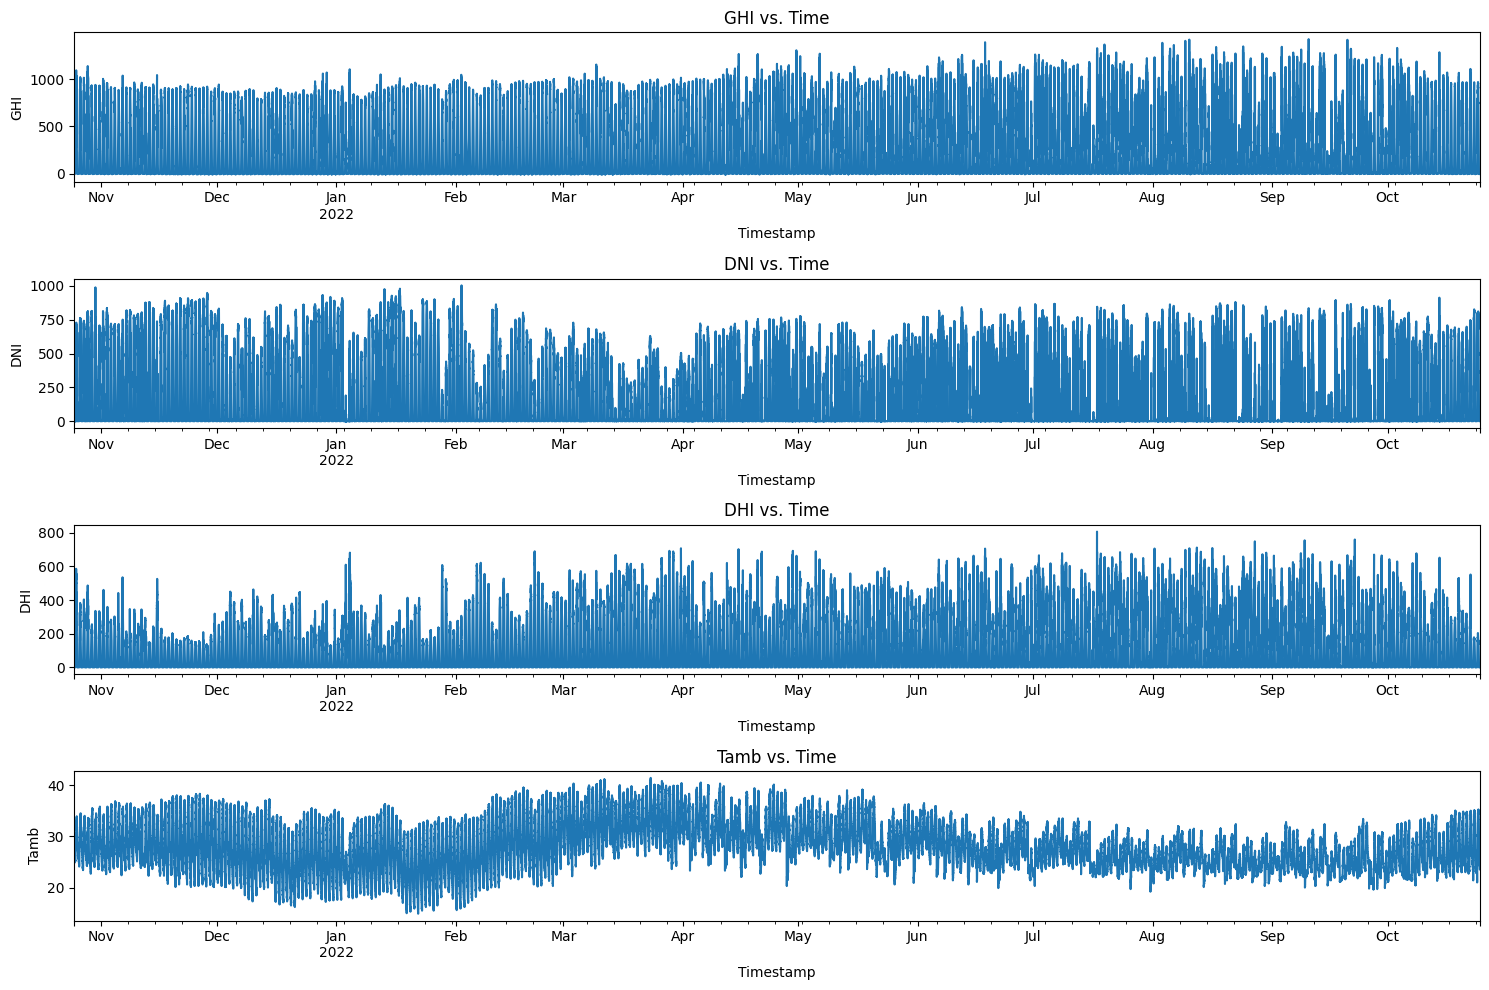

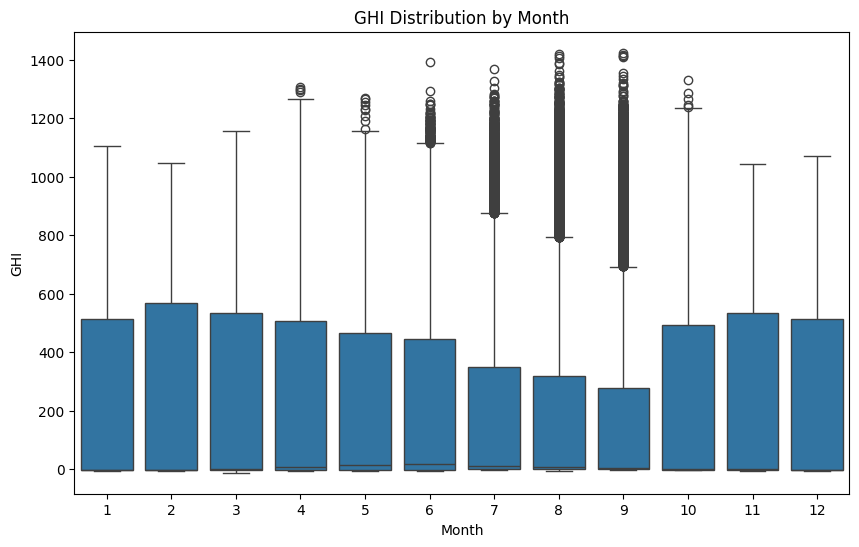

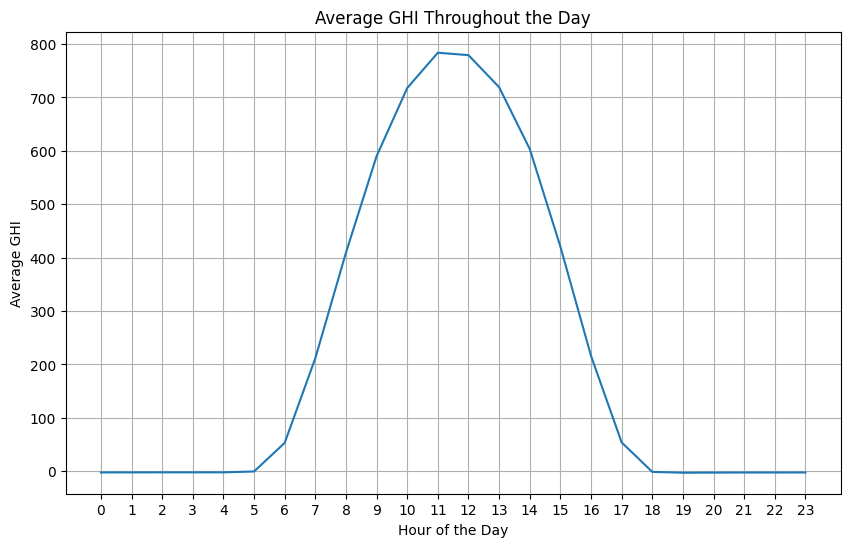

In [11]:
if 'Timestamp' in df.columns:
    try:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df.set_index('Timestamp', inplace=True)

        time_series_cols = ['GHI', 'DNI', 'DHI', 'Tamb']
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(time_series_cols, 1):
            if col in df.columns:
                plt.subplot(len(time_series_cols), 1, i)
                df[col].plot(title=f'{col} vs. Time')
                plt.ylabel(col)
        plt.tight_layout()
        plt.show()

        if 'GHI' in df.columns:
            df['Month'] = df.index.month
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='Month', y='GHI', data=df)
            plt.title('GHI Distribution by Month')
            plt.xlabel('Month')
            plt.ylabel('GHI')
            plt.show()
            df.drop(columns=['Month'], inplace=True)

            df['Hour'] = df.index.hour
            plt.figure(figsize=(10, 6))
            sns.lineplot(x='Hour', y='GHI', data=df.groupby('Hour')['GHI'].mean().reset_index())
            plt.title('Average GHI Throughout the Day')
            plt.xlabel('Hour of the Day')
            plt.ylabel('Average GHI')
            plt.xticks(range(24))
            plt.grid(True)
            plt.show()
            df.drop(columns=['Hour'], inplace=True)

    except KeyError as e:
        print(f"Error: Column '{e}' not found for Time Series Analysis.")
    except Exception as e:
        print(f"An error occurred during Time Series Analysis: {e}")
else:
    print("Warning: 'Timestamp' column not found, skipping Time Series Analysis.")

## ***  Summary Statistics & Missing-Value Report  ***


--- Average ModA & ModB Pre/Post Cleaning ---
                     ModA        ModB
Cleaning Flag                        
0              219.380751  213.028150
1              603.659248  584.626257


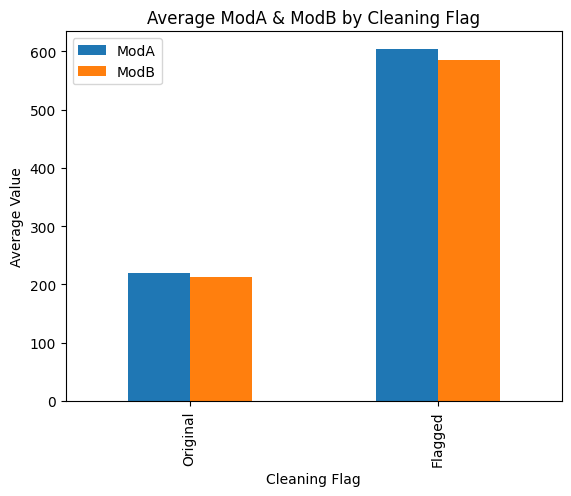

In [12]:
if 'Cleaning Flag' in df.columns and 'ModA' in df.columns and 'ModB' in df.columns:
    cleaning_impact = df.groupby('Cleaning Flag')[['ModA', 'ModB']].mean()
    print("\n--- Average ModA & ModB Pre/Post Cleaning ---")
    print(cleaning_impact)
    cleaning_impact.plot(kind='bar', title='Average ModA & ModB by Cleaning Flag')
    plt.ylabel('Average Value')
    plt.xticks(ticks=[0, 1], labels=['Original', 'Flagged'])
    plt.show()

# *** Correlation & Relationship Analysis ***

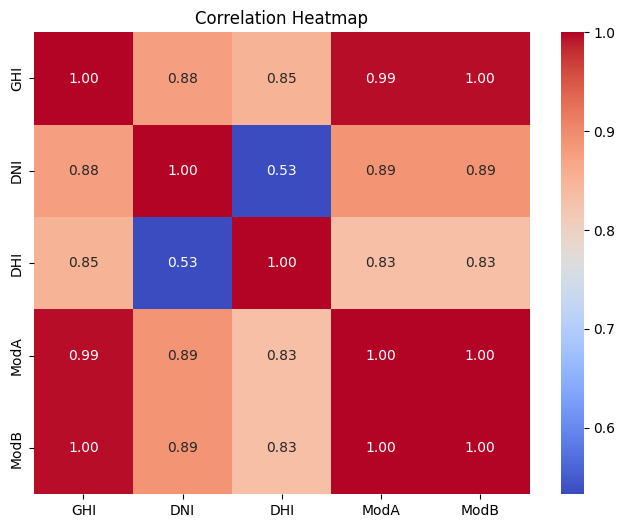

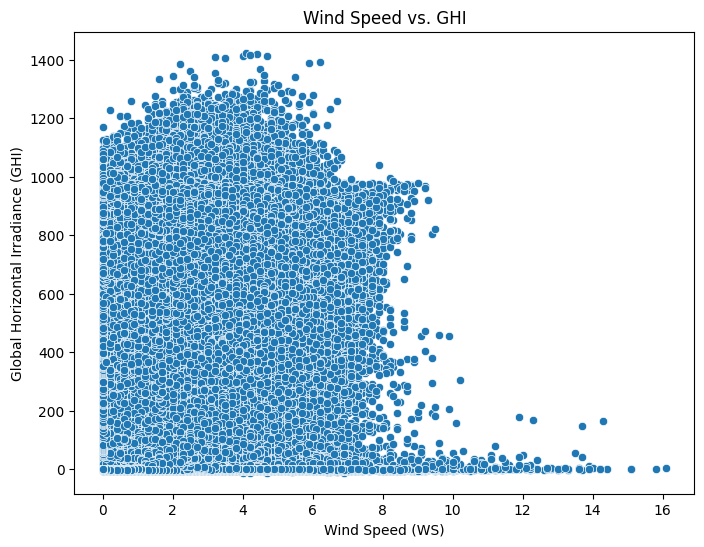

In [13]:
corr_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB'] # Add temperature columns if available
valid_corr_cols = [col for col in corr_cols if col in df.columns]
if valid_corr_cols:
    corr_df = df[valid_corr_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()

if 'WS' in df.columns and 'GHI' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='WS', y='GHI', data=df)
    plt.title('Wind Speed vs. GHI')
    plt.xlabel('Wind Speed (WS)')
    plt.ylabel('Global Horizontal Irradiance (GHI)')
    plt.show()

# *** Wind & Distribution Analysis ***

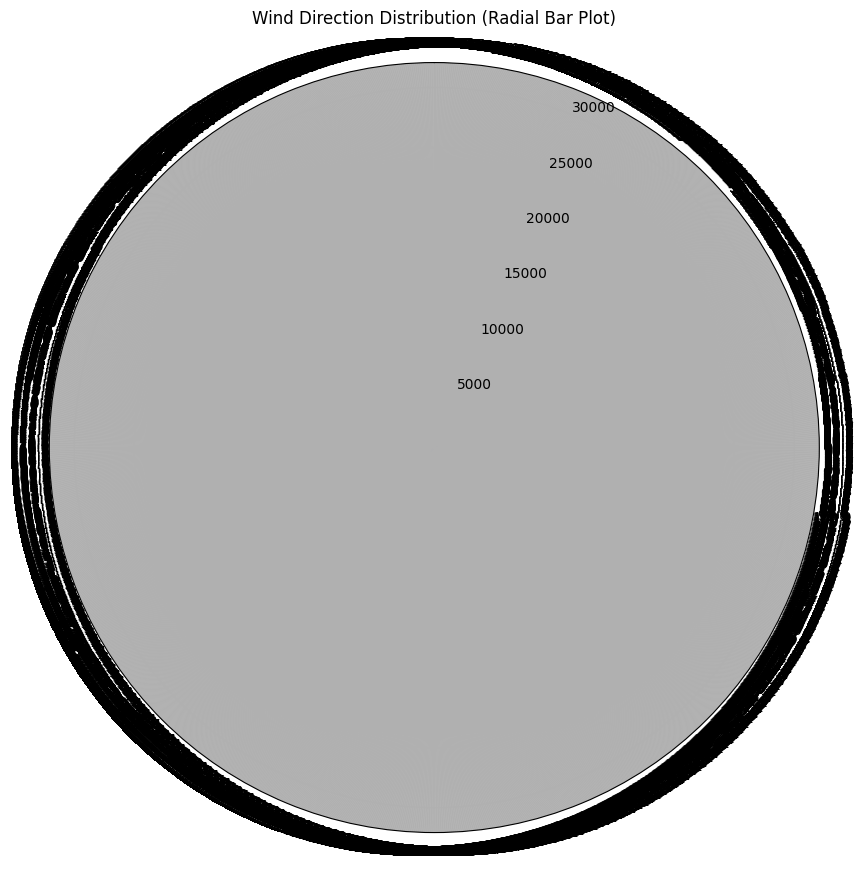

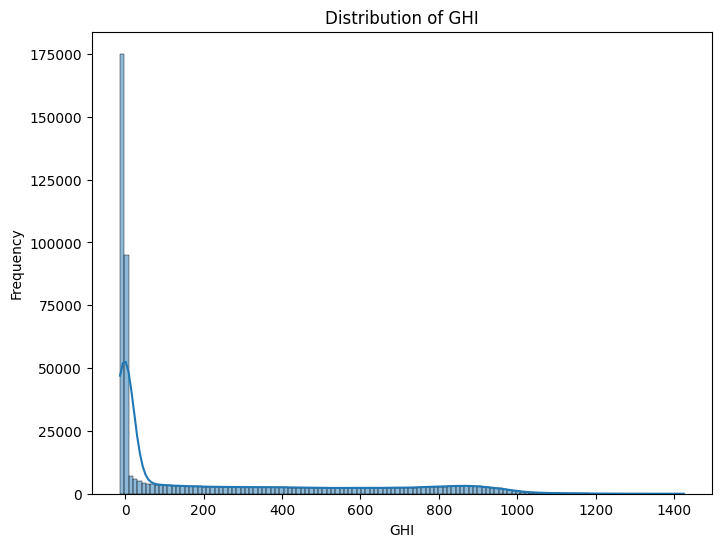

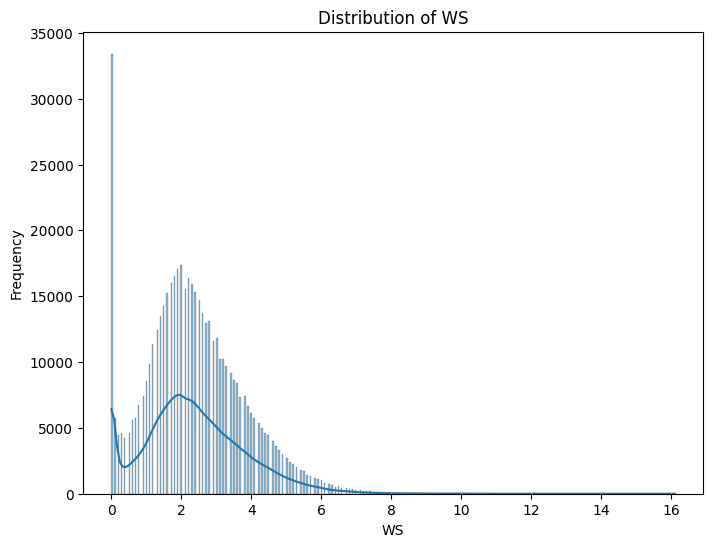

In [14]:
if 'WS' in df.columns and 'WD' in df.columns:
    try:
        import numpy as np
        wd_counts = df['WD'].value_counts().sort_index()
        plt.figure(figsize=(10, 10))
        ax = plt.subplot(111, projection='polar')
        theta = np.linspace(0, 2*np.pi, len(wd_counts), endpoint=False)
        width = 2*np.pi / len(wd_counts)
        bars = ax.bar(theta, wd_counts.values, width=width, bottom=0.0)
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        ax.set_xticks(theta)
        ax.set_xticklabels(wd_counts.index)
        plt.title('Wind Direction Distribution (Radial Bar Plot)', va='bottom')
        plt.show()
    except Exception as e:
        print(f"An error occurred during Wind Direction analysis: {e}")

hist_cols = ['GHI', 'WS']
for col in hist_cols:
    if col in df.columns:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

# *** Temperature Analysis ***

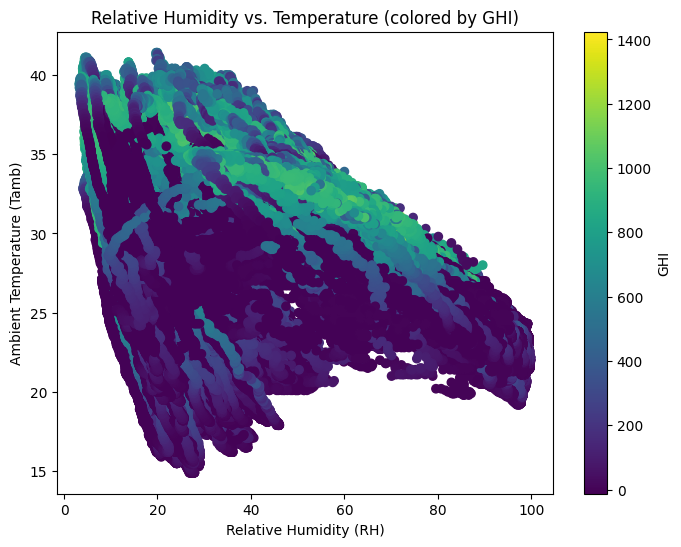

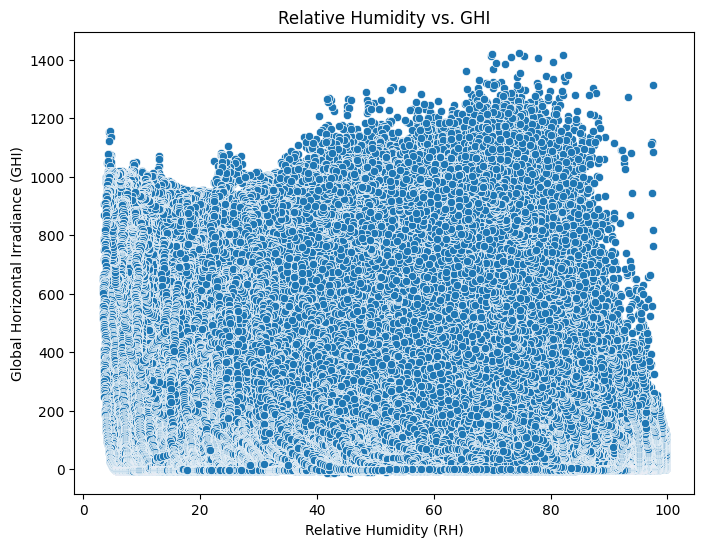

In [15]:
if 'RH' in df.columns and 'Tamb' in df.columns and 'GHI' in df.columns:
    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(df['RH'], df['Tamb'], c=df['GHI'], cmap='viridis')
    plt.title('Relative Humidity vs. Temperature (colored by GHI)')
    plt.xlabel('Relative Humidity (RH)')
    plt.ylabel('Ambient Temperature (Tamb)')
    plt.colorbar(sc, label='GHI')  # Now valid
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='RH', y='GHI', data=df)
    plt.title('Relative Humidity vs. GHI')
    plt.xlabel('Relative Humidity (RH)')
    plt.ylabel('Global Horizontal Irradiance (GHI)')
    plt.show()

# *** Bubble Chart ***

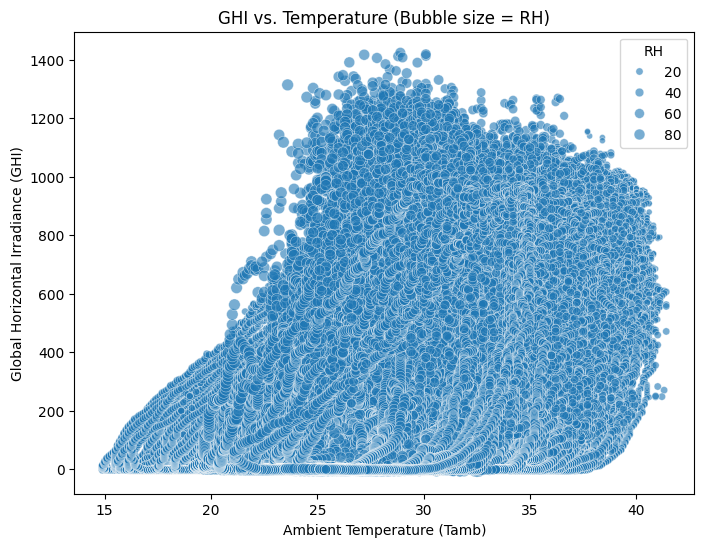

In [16]:
if 'GHI' in df.columns and 'Tamb' in df.columns and 'RH' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Tamb', y='GHI', size='RH', alpha=0.6, data=df)
    plt.title('GHI vs. Temperature (Bubble size = RH)')
    plt.xlabel('Ambient Temperature (Tamb)')
    plt.ylabel('Global Horizontal Irradiance (GHI)')
    plt.show()